If we have a matrix $A + B$ where $B$ is a perturbation on top of $A$ then 
$$(A+B)\approx A^{-1} + (A^{-1} B) A^{-1} $$

In [1]:
import numpy as np

In [2]:
A = np.diag([1,2,3])

In [3]:
B = np.array([[1.,2,3],
             [4,5,6],
             [7,8,9]])
B *= 1e-3

In [4]:
import matplotlib.pyplot as plt

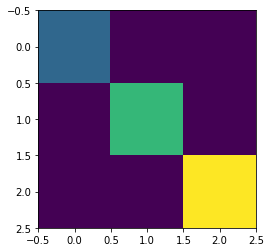

In [5]:
plt.imshow(A)

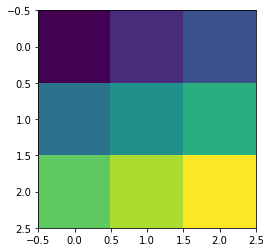

In [6]:
plt.imshow(B)

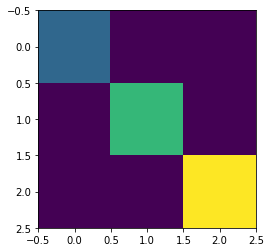

In [7]:
plt.imshow(A+B)

In [8]:
invAB = np.linalg.inv(A+B)

In [9]:
Ainv = np.diag([1, 1/2, 1/3])
invAB_approx = Ainv - (Ainv @ B) @ Ainv

In [10]:
print(Ainv)

[[1.         0.         0.        ]
 [0.         0.5        0.        ]
 [0.         0.         0.33333333]]


In [11]:
print(invAB_approx)

[[ 0.999      -0.001      -0.001     ]
 [-0.002       0.49875    -0.001     ]
 [-0.00233333 -0.00133333  0.33233333]]


In [12]:
from LIMxCMBL.cross_spectrum import *
from LIMxCMBL.init import *
from LIMxCMBL.noise import *

In [13]:
# CCAT-prime
zmin = 3.5
zmax = 8.1
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
window = np.where((chis_resample > chimin) & (chis_resample < chimax))[0]


Lambdas = np.logspace(-4, -1, 50)
Lambda = Lambdas[13]
chis_resample_len = 14

oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_%.5e_chi_sample_2e%d'%(zmin, zmax, Lambda,chis_resample_len)
eIeI = np.load(oup_fname + 'eIeI.npy')
eIeLO = np.load(oup_fname + 'eIeLO.npy' ,)
eLOeI = np.load(oup_fname + 'eLOeI.npy' , )
eLOeLO = np.load(oup_fname + 'eLOeLO.npy', )
eHIeHI = eIeI + eLOeLO - eIeLO - eLOeI

IHi_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_2e%d.npy'%(zmin, zmax, Lambda,chis_resample_len)
IHi_kappa = np.load(IHi_kappa_fname) #[kJy/sr Mpc]
IHi_kappa_windowed = IHi_kappa[:, window].astype(np.float64)



In [14]:
L = np.linalg.cholesky(eHIeHI)
y = np.linalg.solve(L, IHi_kappa_windowed.T)
x = np.linalg.solve(L.T, y)
res1 = np.einsum('ij, ji->i', IHi_kappa_windowed, x)


In [15]:
eIeI_inv = np.diag(1.0 / np.diag(eIeI))
B = eLOeLO-eIeLO-eLOeI
_tmp = eIeI_inv @ B

result = eIeI_inv
term = eIeI_inv
for i in range(1, 20):
    term = -term @ _tmp
    result += term
    
covInv = result
res2 = np.einsum('ai, ij, ja -> a', IHi_kappa_windowed, covInv, IHi_kappa_windowed.T)

In [16]:
diag = np.diag(np.diag(eHIeHI))
Dinv = np.diag(1 / np.diag(diag))
off_diag = eHIeHI - diag

B = off_diag
_tmp = Dinv @ B

result = Dinv
term = Dinv
for i in range(20):
    term = -term @ _tmp
    result += term
    
covInv = result
res3 = np.einsum('ai, ij, ja -> a', IHi_kappa_windowed, covInv, IHi_kappa_windowed.T)

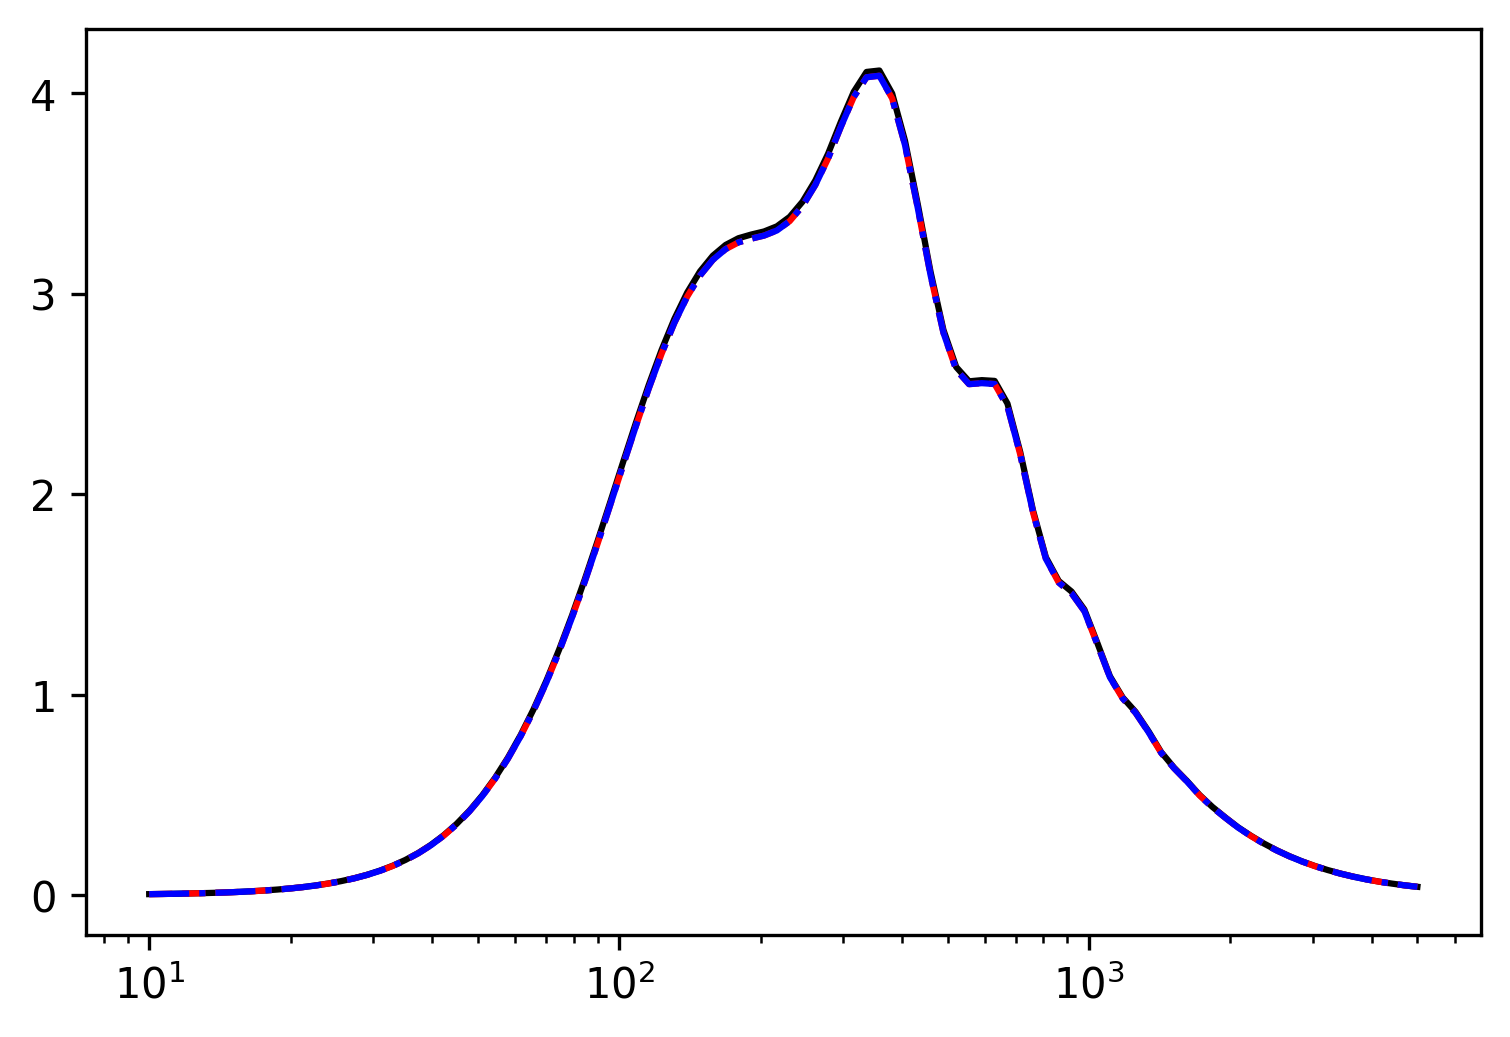

In [17]:
plt.figure(dpi = 300)
plt.plot(ells, ells**2 * res1, 'k')
plt.plot(ells, ells**2 * res2, 'r--')
plt.plot(ells, ells**2 * res3, 'b-.')

plt.xscale('log')

In [18]:
from tqdm import tqdm, trange

In [19]:
def pertur(order):
    diag = np.diag(np.diag(eHIeHI))
    Dinv = np.diag(1 / np.diag(diag))
    off_diag = eHIeHI - diag

    B = off_diag
    _tmp = Dinv @ B

    result = Dinv
    term = Dinv
    for i in trange(order):
        term = -term @ _tmp
        result += term

    covInv = result
    return np.einsum('ai, ij, ja -> a', IHi_kappa_windowed, covInv, IHi_kappa_windowed.T)

100%|██████████| 100/100 [00:21<00:00,  4.58it/s]


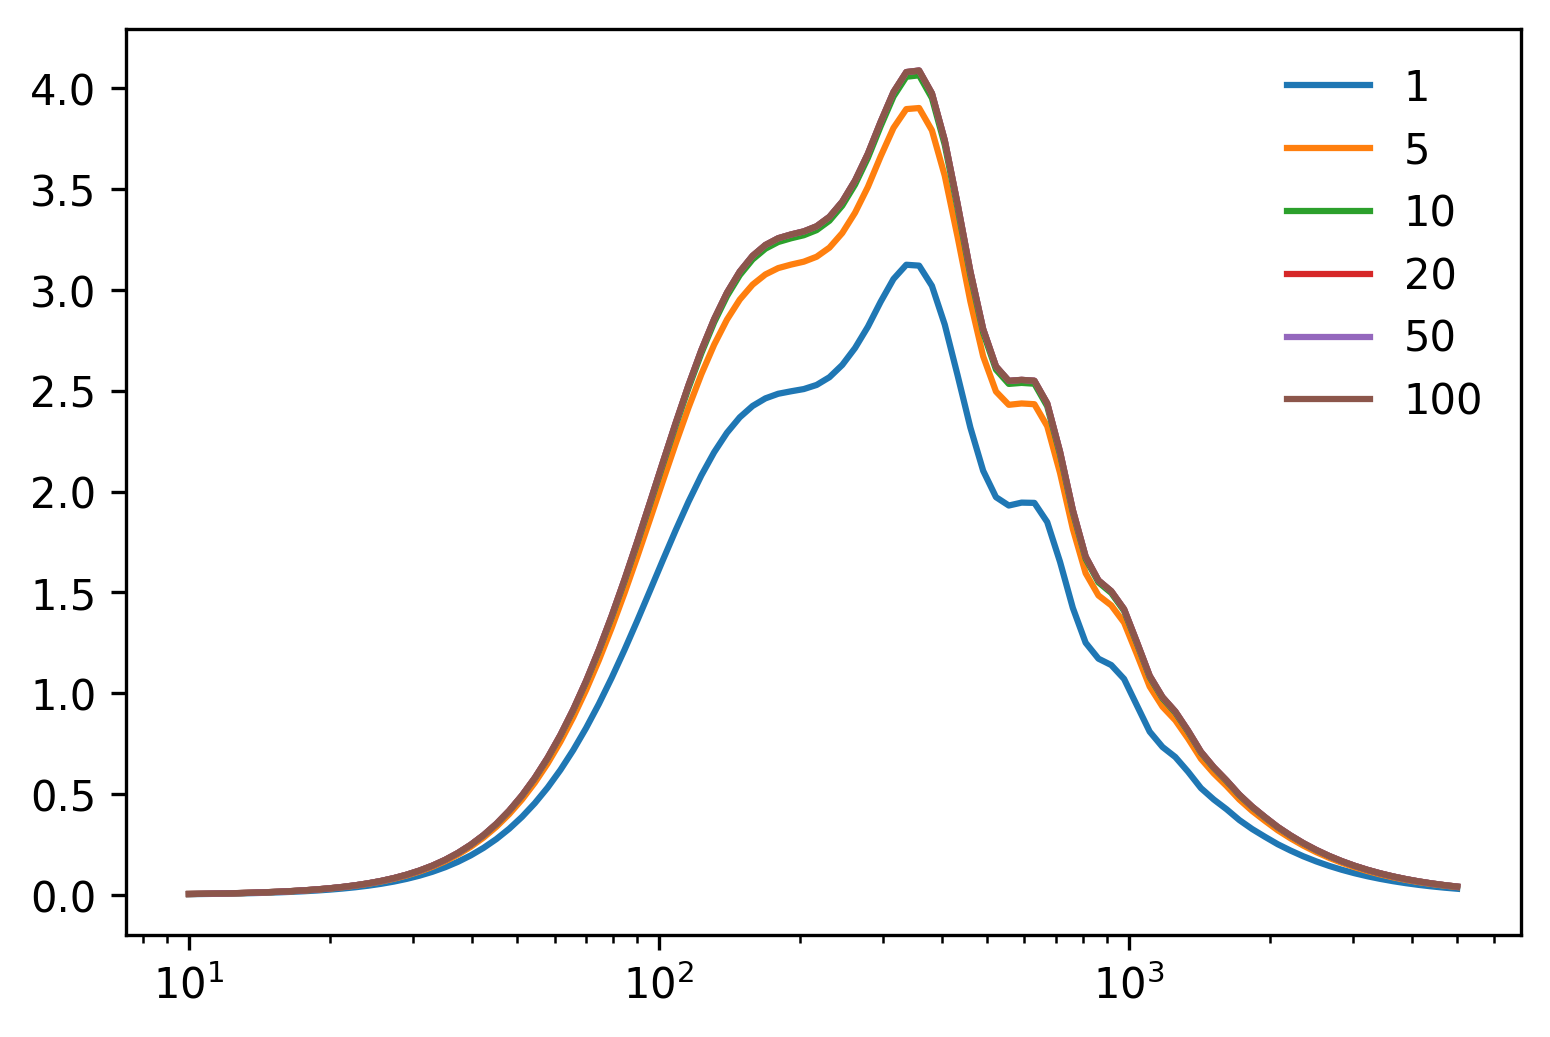

In [20]:
plt.figure(dpi = 300)

for order in ([1, 5, 10, 20, 50, 100]):
    plt.plot(ells, ells**2 * pertur(order), label=order)

plt.legend(frameon = False)
plt.xscale('log')

In [21]:
def pertur2(order):
    eIeI_inv = np.diag(1.0 / np.diag(eIeI))
    B = eLOeLO-eIeLO-eLOeI
    _tmp = eIeI_inv @ B

    result = eIeI_inv
    term = eIeI_inv
    for i in trange(order):
        term = -term @ _tmp
        result += term

    covInv = result
    return np.einsum('ai, ij, ja -> a', IHi_kappa_windowed, covInv, IHi_kappa_windowed.T)

100%|██████████| 200/200 [00:43<00:00,  4.55it/s]


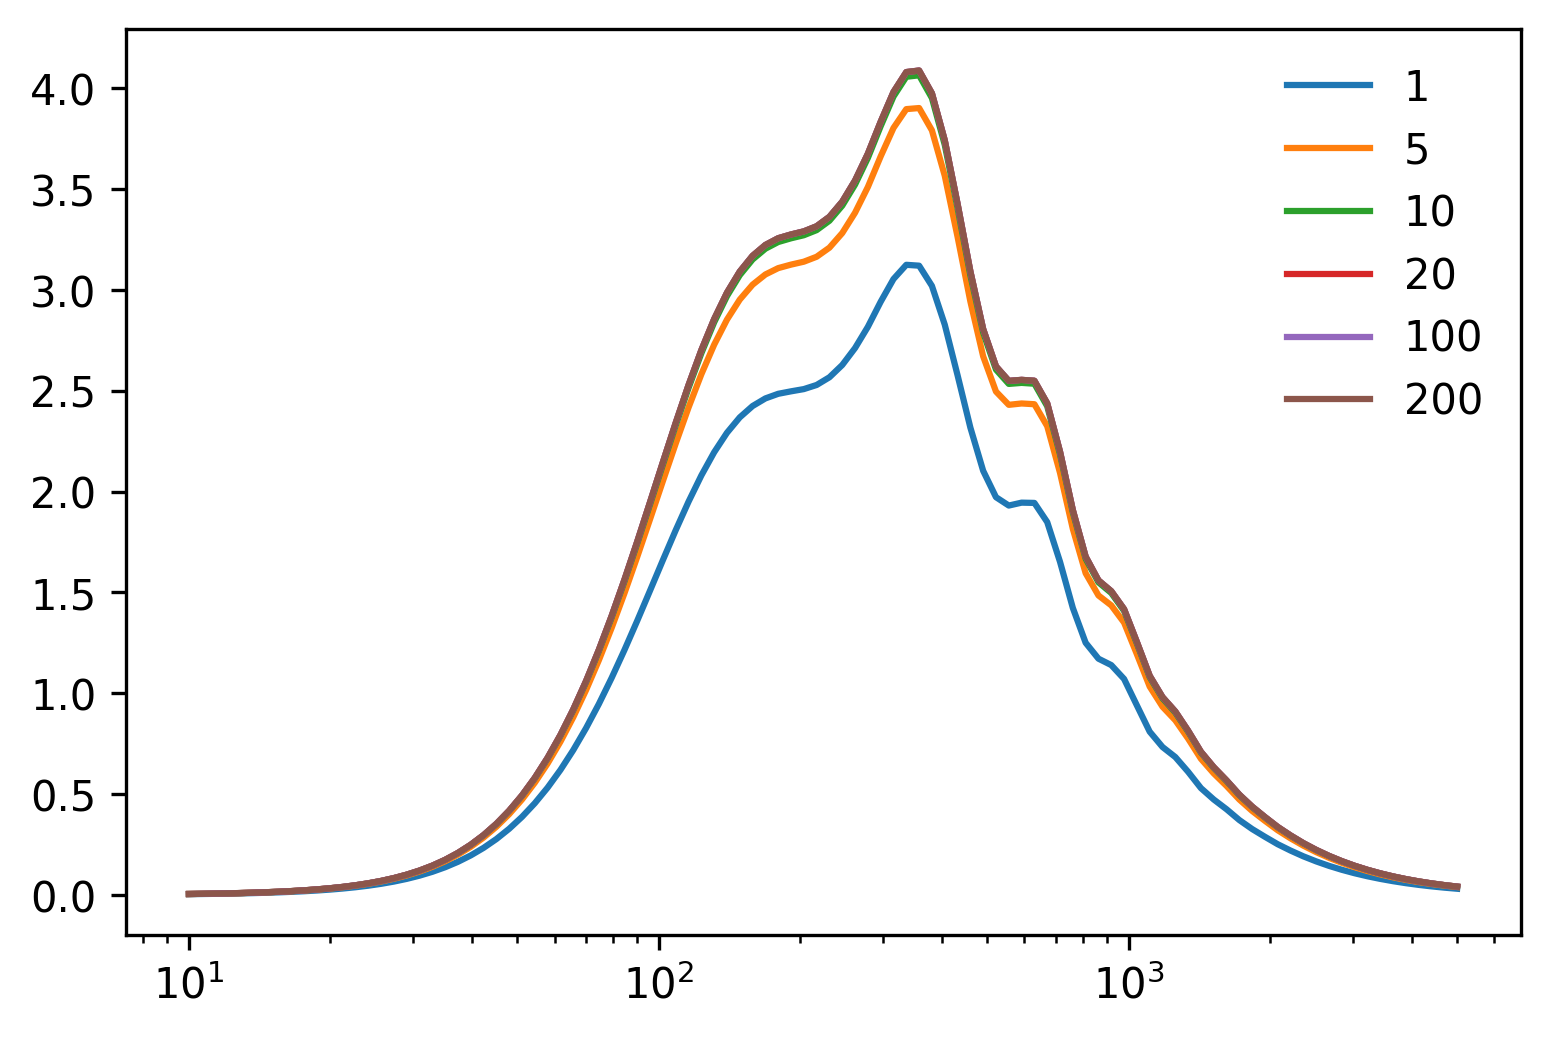

In [22]:
plt.figure(dpi = 300)

for order in ([1, 5, 10, 20, 100, 200]):
    plt.plot(ells, ells**2 * pertur2(order), label=order)

plt.legend(frameon = False)
plt.xscale('log')